## Задание 1. Применение метода экспоненциального сглаживания

В данном задании вам необходимо построить модель прогнозирования для временного ряда `pigs.csv`.

<ol>
 
  <li>Реализуйте функцию экспоненциального сглаживания, которая принимает на вход три параметра: `y`, `alpha` и `level` и возвращает прогноз на следующую точку. Здесь
   <ul>
          <li>`y` $-$ исходный временной ряд;</li>
          <li>`alpha` $-$ значение параметра сглаживания $\alpha$;</li>
          <li>`level` $-$ начальное значение уровня $l_0$.</li>
          <p></p>
      </ul>
      Получите прогноз с произвольным `alpha` и `level=y[0]`.
 </li>
 <p></p>
 
  <li>Модифицируйте функцию таким образом, чтобы она возвращала не прогноз на следующую точку, а значение среднеквадратичной ошибки:</li>
  <p></p>
  $$MSE=\frac{1}{T-1}\sum_{t=2}^{T} (y_t-\hat{y}_t)^{2}.$$
  <p></p>
<li>С помощью функции `scipy.optimize.minimize()` найдите такие параметры `alpha`, `level`, при которых MSE минимальна. Сравните полученное значение ошибки с MSE на параметрах из пункта 1.</li>

</ol>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
import glob

In [4]:
directory = '*.csv' 
files = glob.glob(directory)[1]
files

'pigs.csv'

In [5]:
df = pd.read_csv(files,index_col=0, parse_dates=True)

In [6]:
df.head()

,Total number of pigs slaughtered in Victoria
Month,
1980-01-01,76378
1980-02-01,71947
1980-03-01,33873
1980-04-01,96428
1980-05-01,105084


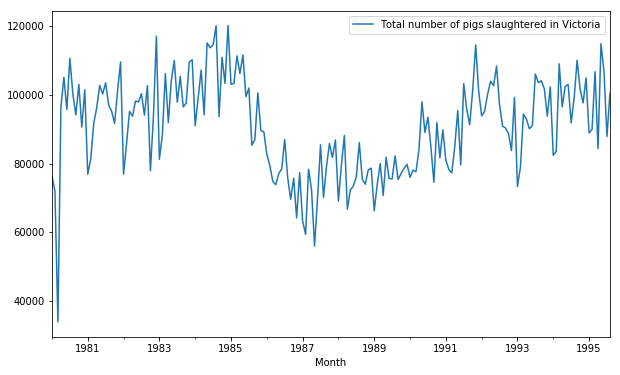

In [7]:
df.plot(figsize=(10, 6))

In [8]:
df.shape

(188, 1)

In [9]:
df.index.values[[0,1,2]]

array(['1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
data =df.drop(df.index.values[[0,1,2]])

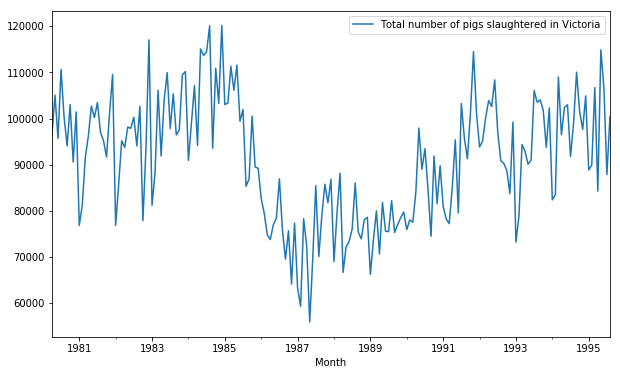

In [11]:
data.plot(figsize=(10, 6))

In [12]:
y = data['Total number of pigs slaughtered in Victoria'].values

  <li>Реализуйте функцию экспоненциального сглаживания, которая принимает на вход три параметра: `y`, `alpha` и `level` и возвращает прогноз на следующую точку. Здесь
   <ul>
          <li>`y` $-$ исходный временной ряд;</li>
          <li>`alpha` $-$ значение параметра сглаживания $\alpha$;</li>
          <li>`level` $-$ начальное значение уровня $l_0$.</li>
          <p></p>
      </ul>
      Получите прогноз с произвольным `alpha` и `level=y[0]`.
 </li>
 <p></p>

In [13]:
def exponential(y,alpha,level):
    b=y.copy()
    for i in range(0, len(b)-1):
        level = b[i+1]
        b[i+1] = b[i]*alpha + (1-alpha)*level
       
        
    return b

In [14]:
data['exp_prognose'] = exponential(y,0.5,y[0])

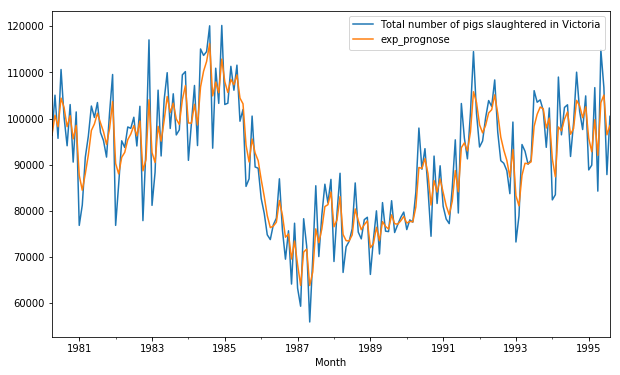

In [15]:
data.plot(figsize=(10, 6))

In [16]:
def MSE(y_real, y_pred):
    result = sum(i for i in [num**2 for num in [a_i - b_i for a_i, b_i in zip(y_real, y_pred)]])/len(y_real)
    return result

In [17]:
def exponential_mse(y,alpha,level):
    b=y.copy()
    for i in range(0, len(b)-1):
        level = b[i+1]
        b[i+1] = b[i]*alpha + (1-alpha)*level
    result = MSE(b,y)
    return result

In [18]:
exponential_mse(y,0.5,y[0])

22187393.56756757

In [19]:
from scipy.optimize import minimize

In [20]:
def exponential_find_minimum(alpha,level,y):
    b=y.copy()
    for i in range(0, len(b)-1):
        level = b[i+1]
        b[i+1] = b[i]*alpha + (1-alpha)*level
    result = MSE(b[1:len(b)],y[1:len(y)])
    return result

In [21]:
res = minimize(lambda arr: exponential_find_minimum(arr[0], arr[1], y), x0=[0.5, data['Total number of pigs slaughtered in Victoria'].mean()])
result = res.x[0]
result

0.16352791674378764

In [26]:
res

      fun: 2997130.6195652173
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([1.63527917e-01, 9.11254324e+04])

# 2

$$\hat{y}_{t+h\, |\, t}=l_t+h\, b_t+s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, (y_t-s_{t-m})+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, (y_t-l_{t-1}-b_{t-1})+(1-\gamma)\, s_{t-m}\, .$$

В случае, когда сезонные колебания изменяются пропорционально уровню ряда, говорят о мультипликативной сезонности. В данном случае мультипликативный метод Хольта-Уинтерса является более предпочтительным:

$$\hat{y}_{t+h\, |\, t}=(l_t+h\, b_t)\, s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, \frac{y_t}{s_{t-m}}+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, \frac{y_t}{l_{t-1}+b_{t-1}}+(1-\gamma)\, s_{t-m}\, .$$

При аддитивном методе сезонная компонента $s_t$ выражается в абсолютных величинах в масштабе наблюдаемого ряда, а в уравнении уровня ряд сезонно корректируется путем вычитания из него сезонной компоненты. При использовании же мультипликативного метода сезонная компонента выражается в относительных единицах, а ряд корректируется путем деления значений на сезонную компоненту.

В этом задании будем использовать данные о количестве ночей, проведенных иностранцами в гостинице Австралии `austourists.csv`.

<ol>
 
  <li>Реализуйте аддитивный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.306, \beta=0.0003, \gamma=0.426$. Оцените качество модели с помощью метрики RMSE:</li>
$$RMSE=\sqrt{\frac{1}{T-4}\sum_{t=5}^{T} (y_t-\hat{y}_t)^{2}}.$$
 <p></p>
 <li>Реализуйте мультипликативный метод Хольта-Уинтерса. Постройте прогноз на одну точку вперед при $\alpha=0.441, \beta=0.03, \gamma=0.002$. Сравните качество результатов с полученными с помощью аддитивной модели.</li>

</ol>

In [22]:
directory = '*.csv' 
files = glob.glob(directory)[0]
files

'austourists.csv'

In [23]:
df_1 = pd.read_csv(files,index_col=0, parse_dates=True)

In [24]:
df_1.head()

,time,value
21,2004.00,41.273599
22,2004.25,26.655862
23,2004.50,28.279859
24,2004.75,35.191153
25,2005.00,42.205664


$$\hat{y}_{t+h\, |\, t}=l_t+h\, b_t+s_{t-m+h\bmod m }\, ,$$
$$l_t=\alpha\, (y_t-s_{t-m})+(1-\alpha)\, (l_{t-1}+b_{t-1}),$$
$$b_t=\beta\, (l_t-l_{t-1})+(1-\beta)\, b_{t-1},$$
$$s_t=\gamma\, (y_t-l_{t-1}-b_{t-1})+(1-\gamma)\, s_{t-m}\, .$$

In [25]:
def holt_winters(y,alpha,beta,lmbda,level):
    h = 1
    l = 1
    t = 1
    b=y.copy()
    for i in range(0, len(b)-1):
        alpha
        level = b[i+1]
        b[i+1] = b[i]*alpha + (1-alpha)*level
       
        
    return b